# Projet Python 2025

# Etape 5 : Interprétation et visualisation

## Affichage des 5 dernières alertes

In [757]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("alertes_enrichies.csv")
df.tail()


,Titre Alerte,Type,Description,Lien,Date,CVE ID,Description CVE,CWE,Nature de la faille,Score CVSS,Gravité CVSS,Score EPSS,Gravité EPSS,Éditeur,Produit,Versions Affectées
35,Multiples vulnérabilités dans le noyau Linux d...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2024-50067,"In the Linux kernel, the following vulnerabili...",Non disponible,Non disponible,NaN,Non disponible,0.00031,Faible,Linux,Linux,3.14
36,Multiples vulnérabilités dans le noyau Linux d...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-40048,"In the Linux kernel, the following vulnerabili...",Non disponible,Non disponible,NaN,Non disponible,0.00053,Faible,Linux,Linux,4.10
37,Multiples vulnérabilités dans les produits IBM...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-36047,IBM WebSphere Application Server Liberty 18.0....,CWE-770,CWE-770 Allocation of Resources Without Limits...,5.3,Moyenne,0.00085,Faible,IBM,WebSphere Application Server Liberty,18.0.0.2
38,Vulnérabilité dans Microsoft Edge (09 janvier ...,Avis,Une vulnérabilité a été découverte dans Micros...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-62224,User interface (ui) misrepresentation of criti...,CWE-451,CWE-451: User Interface (UI) Misrepresentation...,5.5,Moyenne,0.00062,Faible,Microsoft,Microsoft Edge for Android,1.0.0
39,Multiples vulnérabilités dans les produits Mic...,Avis,De multiples vulnérabilités ont été découverte...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-11964,"On Windows only, if libpcap needs to convert a...",CWE-787,CWE-787 Out-of-bounds Write,1.9,Faible,0.00015,Faible,The Tcpdump Group,libpcap,1.10.0


## Lien entre score CVSS et score EPSS

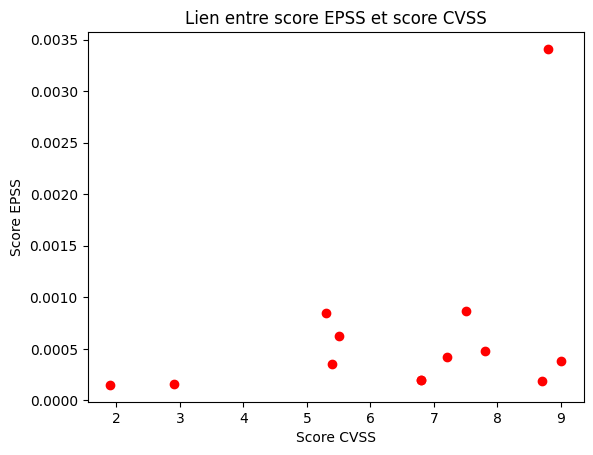

In [758]:
plt.plot(df.get("Score CVSS"), df.get("Score EPSS"), "ro")
plt.title("Lien entre score EPSS et score CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.show()

Ce graphique en nuage de points montre la corrélation entre les deux scores de sévérité.

CVSS = potentiel technique d'exploitabilité
EPSS = probabilité réelle d'exploitation
Si les points sont dispersés, cela signifie que certaines vulnérabilités techniquement graves ne sont pas forcément exploitées en pratique (bon signe de sécurité).

## Nombre d'alertes par produit

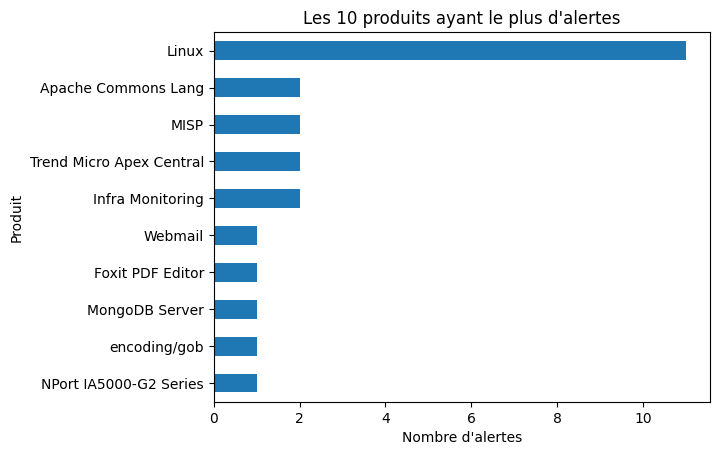

In [759]:
alertes_produit = df["Produit"].value_counts().nlargest(10)
alertes_produit.plot(kind="barh")
plt.title("Les 10 produits ayant le plus d'alertes")
plt.xlabel("Nombre d'alertes")
plt.gca().invert_yaxis()
plt.show()

Ce diagramme en barres horizontales classe les produits les plus affectés par les vulnérabilités. Les produits en haut ont le plus d'alertes de sécurité, ce qui devrait être votre priorité pour les correctifs.

## Diagramme circulaire des types de vulnérabilités + détails dans un tableau

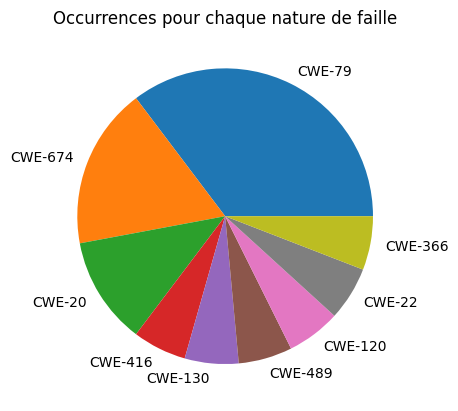

,count
Nature de la faille,
CWE-79 Improper Neutralization of Input During Web Page Generation (XSS or 'Cross-site Scripting'),4
CWE-674 Uncontrolled Recursion,3
CWE-416 Use After Free,1
CWE-674: Uncontrolled Recursion,1
CWE-130: Improper Handling of Length Parameter Inconsistency,1
CWE-20 Improper Input Validation,1
CWE-20: Improper Input Validation,1
CWE-489: Active Debug Code,1
CWE-120,1


In [760]:

nb_cwe = df["CWE"].value_counts().nlargest(10)
nb_cwe = nb_cwe.drop(labels=["Non disponible"])
nb_cwe.plot(kind="pie")
plt.xlabel("")
plt.ylabel("")
plt.title("Occurrences pour chaque nature de faille")
plt.show()

nb_nature_faille = df["Nature de la faille"].value_counts()
nb_nature_faille = nb_nature_faille.drop(labels=["Non disponible"])

df_nature_faille = pd.DataFrame(nb_nature_faille)
df_nature_faille

Le diagramme circulaire montre la répartition des types de failles détectées (injection SQL, XSS, authentification faible...).
La parts les plus grandes représentent les catégories de vulnérabilités les plus fréquentes
Le tableau qui suit détaille le nombre exact d'occurrences par type de faille


## Editeurs ayant le score EPSS le plus élevé

In [761]:
epss_editeur = df.nlargest(10, "Score EPSS")[["Éditeur", "Score EPSS"]]
epss_editeur

,Éditeur,Score EPSS
8,MongoDB Inc.,0.69622
33,NaN,0.68749
13,vllm-project,0.00341
21,MariaDB,0.00124
20,QNAP Systems Inc.,0.00107
5,Go standard library,0.00087
29,"Trend Micro, Inc.",0.00087
37,IBM,0.00085
24,tukaani-project,0.00077
38,Microsoft,0.00062


Ce tableau affiche les 10 vulnérabilités avec les plus hauts risques d'exploitation réelle. L'éditeur associé montre qui doit être contacté en priorité pour les correctifs critiques.